# Part 1 - Libraries for the Contig Analysis

In [2]:
from Bio import SeqIO
from Bio.Blast import NCBIWWW
from collections import Counter
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Part 2 - Basic Genome Assembly Stats

## Genome Length

In [3]:
# genome length
with open("../assembly_version2/assembly.fasta") as handle:
    print("file loaded")
    length = 0 
    for record in SeqIO.parse(handle, "fasta"):
        length += len(record.seq)
    print(length)


file loaded
51390606


## GC% per contig

In [4]:
ids = []
gc_frequency = []

#focusing on the new version of the genome assembly
with open("../assembly_version2/assembly.fasta") as handle:
    print("file loaded")
    for record in SeqIO.parse(handle, "fasta"):
       id = record.id
       ids.append(record.id)
       counter = Counter(record.seq.lower())
       gc = (counter['g'] + counter['c'])/len(record.seq)
       gc_frequency.append(gc)
       print("{},{}".format(id,gc))

file loaded
contig_1,0.6513192253859491
contig_10,0.5665818490245971
contig_100,0.6635542168674698
contig_101,0.6467631147243375
contig_102,0.660989598410956
contig_103,0.6567457307775214
contig_104,0.6425522622143693
contig_105,0.6128437697046127
contig_106,0.640112220264892
contig_107,0.664010761589404
contig_108,0.6372554468652735
contig_109,0.637852526439483
contig_11,0.6605609015051354
contig_110,0.6480224714493675
contig_111,0.6662083757252454
contig_112,0.6515962314939435
contig_113,0.6504959326387898
contig_114,0.6567395802542122
contig_115,0.6502905074098586
contig_116,0.6515014445384772
contig_117,0.6574427849176026
contig_118,0.6659181056174547
contig_119,0.636897500638316
contig_12,0.6518094548723502
contig_120,0.6505064585313856
contig_121,0.6498316498316499
contig_122,0.658721961812452
contig_123,0.6467424046819864
contig_124,0.5981481481481481
contig_125,0.6664803756443628
contig_126,0.6519555322527945
contig_127,0.6580670990471615
contig_128,0.6600606839242271
contig_12

## Average Depth per Contig (calculated using samtools)

In [5]:
average_depth = pd.read_csv("../assembly_version2/contig_depth.csv",sep=" ")
average_depth

,Contig,AverageDepth
0,contig_108,33.5481
1,contig_121,32.6813
2,contig_109,15.0346
3,contig_122,37.9624
4,contig_123,48.1428
...,...,...
287,contig_299,31.7243
288,contig_105,14.8743
289,contig_106,38.3185
290,contig_107,27.7628


## 4-mer frequency per Contig

In [ ]:
import itertools

def generate_tetramers(sequence):
    # Define the nucleotides
    nucleotides = ['A', 'C', 'G', 'T']
    
    # Generate all possible combinations of the sequence
    tetramers = [''.join(p) for p in itertools.product(nucleotides, repeat=len(sequence))]
    
    return tetramers

# Example usage
f = open('kmer_counts.csv', 'w')
sequence = 'AAAA'
tetramers = generate_tetramers(sequence)
header = "{},Contig1".format(','.join(tetramers))
print(header,file=f)
tetramer_counts = dict.fromkeys(tetramers,0)

print(','.join(tetramers))
# Split the multi-FASTA file
for record in SeqIO.parse("../assembly_version2/assembly.fasta", "fasta"):
    start = 0
    end = start + 4
    tetramers = generate_tetramers(sequence)
    tetramer_counts = dict.fromkeys(tetramers,0)
    while(end <= len(record.seq)):
        tetramer = record.seq[start:end].upper()
        tetramer_counts[tetramer] += 1
        start += 1
        end = start + 4
    # compute the frequency of the tetramer counts normalized by the length of the contig
    tetramer_rf = [x/(len(record.seq)) for x in list(tetramer_counts.values())]
    output = ','.join(list(map(str,tetramer_rf)))
    row = "{},{}".format(output,record.id)
    print(row,file=f)
    print(row)
f.close()




# Part 3 - Visualization of Contig Statistics 

## Creating main dataframe

In [10]:
blast_df = pd.read_csv("full_blast_results_v1.out",sep="\t",header=None)
blast_df[1] = blast_df[1].str.replace(r'\d+', '', regex=True).replace('\.', '', regex=True)
genus_lookup = pd.read_csv("genus_lookup.csv")
blast_df = pd.merge(blast_df, genus_lookup, left_on=1, right_on='unique_id', how='left').drop('unique_id', axis=1)

kmer_df = pd.read_csv("kmer_counts.csv")
gc_content = pd.DataFrame({"Contig1":ids,"GC":gc_frequency})
qc_check = pd.merge(gc_content, average_depth, left_on='Contig1', right_on='Contig', how='left').drop('Contig1', axis=1)
contig_check = pd.merge(qc_check,kmer_df,left_on='Contig', right_on='Contig1', how='left').drop('Contig1', axis=1)
blast_check = pd.merge(contig_check,blast_df.loc[:,[0,"genus"]],left_on='Contig', right_on=0, how='left').drop(0, axis=1)

## Contig Statistics 

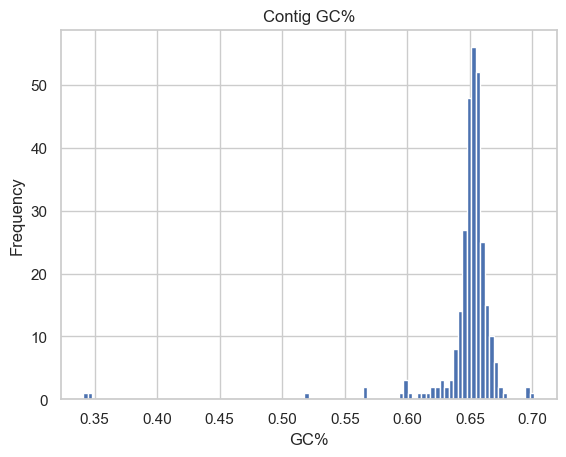

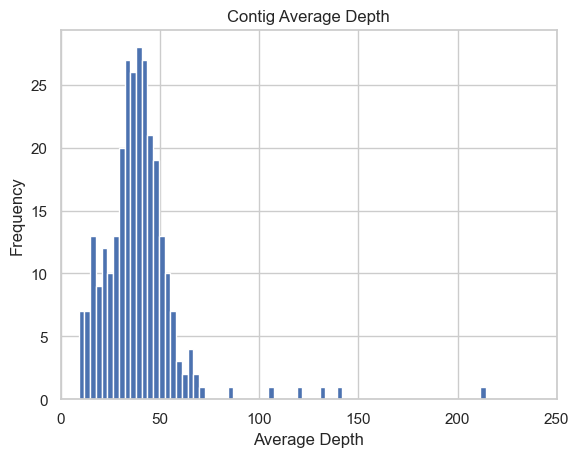

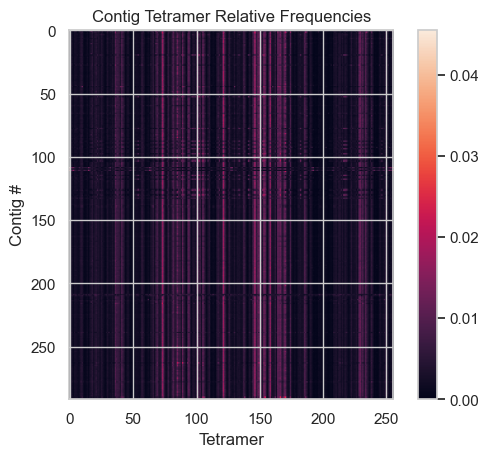

In [11]:
#GC %
sb.set(style='whitegrid')
plt.hist(gc_frequency, bins=100)
plt.title('Contig GC%')
plt.ylabel('Frequency')
plt.xlabel('GC%')
plt.show()

#Depth
sb.set(style='whitegrid')
plt.hist(qc_check['AverageDepth'],bins=1000)
plt.title('Contig Average Depth')
plt.ylabel('Frequency')
plt.xlabel('Average Depth')
plt.xlim(0, 250)
plt.show()

#4-mer
data = contig_check.drop(['GC','AverageDepth','Contig'],axis=1)
plt.imshow( data ) 
  
plt.title( "Contig Tetramer Relative Frequencies" ) 
plt.ylabel('Contig #')
plt.xlabel('Tetramer')
# Add colorbar 
plt.colorbar() 
plt.show() 

## Principal Component Analysis

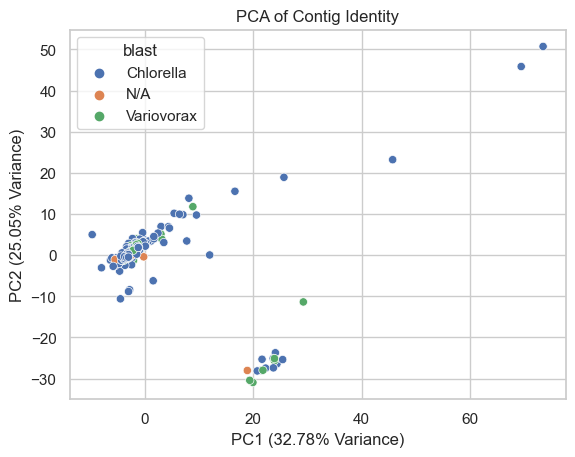

In [13]:
# 1. Standardize the data (PCA works better with standardized data)
cleaned_df = contig_check.drop(['Contig'],axis=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cleaned_df)


# 2. Perform PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_components = pca.fit_transform(scaled_data)


# 3. Create a new DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['blast'] = blast_check['genus'].fillna("N/A")


# 5. Plot the PCA results using Seaborn
sb.scatterplot(x='PC1', y='PC2', data=pca_df,hue=pca_df['blast'])

# Add labels and title
plt.title('PCA of Contig Identity')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0] * 100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1] * 100:.2f}% Variance)')

# Show the plot
plt.show()

# Part 4 - Genome Assembly Stats

In [16]:
# Number of contigs - 292 
# N50 - 316002
# L50 - 51
# Average GC% - 64.8%
# Average Depth - 53.6
from Bio import SeqIO

def get_contig_lengths_from_fasta(fasta_file):
    """
    Extract contig lengths from a FASTA file.
    
    :param fasta_file: Path to the FASTA file.
    :return: List of contig lengths.
    """
    contig_lengths = [len(record.seq) for record in SeqIO.parse(fasta_file, "fasta")]
    return contig_lengths

def compute_n50_l50(contig_lengths):
    """
    Compute N50 and L50 for a given list of contig lengths.

    :param contig_lengths: List of integers representing contig lengths.
    :return: Tuple (N50, L50)
    """
    # Sort lengths in descending order
    contig_lengths.sort(reverse=True)
    
    # Compute total assembly length
    total_length = sum(contig_lengths)
    
    # Find N50 and L50
    cumulative_length = 0
    for i, length in enumerate(contig_lengths):
        cumulative_length += length
        if cumulative_length >= total_length / 2:
            n50 = length
            l50 = i + 1
            return n50, l50

# Example usage
fasta_file = "../assembly_version2/assembly.fasta"
contig_lengths = get_contig_lengths_from_fasta(fasta_file)
n50, l50 = compute_n50_l50(contig_lengths)
print(f"N50: {n50}")
print(f"L50: {l50}")

count = 0.0
for x in gc_frequency:
    count += x 

print(f"GC: {count/len(gc_frequency)}")

ad = average_depth["AverageDepth"].to_list()
count = 0.0
for x in ad:
    count += x 

print(f"Depth: {count/len(ad)}")

N50: 316002
L50: 51
GC: 0.6483932042327147
Depth: 53.59153660958908
